In [227]:
import sys
import os
import numpy as np
from skimage import measure
from functools import partial
from scipy.interpolate import splprep, splev
from scipy.ndimage.filters import uniform_filter
from scipy import ndimage
from skimage import filters, feature, morphology
import matplotlib
import matplotlib.pyplot as plt
import warnings


/var/folders/br/rzkf1nz907qd3q234g81vfm00000gn/T/ipykernel_34155/690596438.py:7: DeprecationWarning: Please import `uniform_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter


In [228]:
from skimage.color import rgb2gray
from skimage import data


im = data.astronaut()
im = rgb2gray(im)

s = np.linspace(0, 2 * np.pi, 400)
r = 100 + 100 * np.sin(s)
c = 220 + 100 * np.cos(s)

mask = np.array([r, c]).T


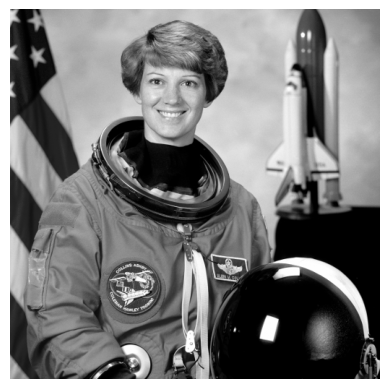

In [229]:
# show the original image
fig = plt.figure()
plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()


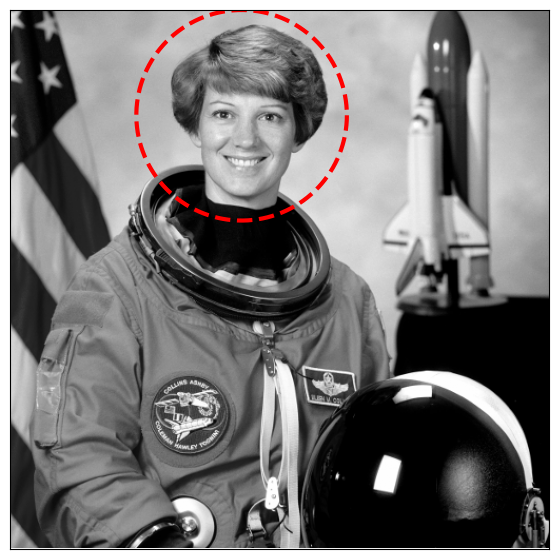

In [230]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(im, cmap=plt.cm.gray)
ax.plot(mask[:, 1], mask[:, 0], '--r', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, im.shape[1], im.shape[0], 0])

plt.show()

In [231]:

def enhance_ridges(frame, mask=None,smoothness=2):
    """Detect ridges (larger Hessian eigenvalue)"""
    blurred = filters.gaussian(frame, smoothness)
    H_elems = feature.hessian_matrix(blurred, sigma=4.5, mode='nearest', order='xy')
    eigvals = feature.hessian_matrix_eigvals(H_elems)
    ridges = eigvals[1]
    return np.abs(ridges)




In [232]:
ridges = enhance_ridges(im,smoothness=3)
thresh = filters.threshold_otsu(ridges)
prominent_ridges = ridges > thresh
skeleton = morphology.skeletonize(prominent_ridges)
edge_dist = ndimage.distance_transform_edt(~skeleton)
edge_dist = filters.gaussian(edge_dist, sigma=2)

/var/folders/br/rzkf1nz907qd3q234g81vfm00000gn/T/ipykernel_34155/1894913289.py:4: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  H_elems = feature.hessian_matrix(blurred, sigma=4.5, mode='nearest', order='xy')


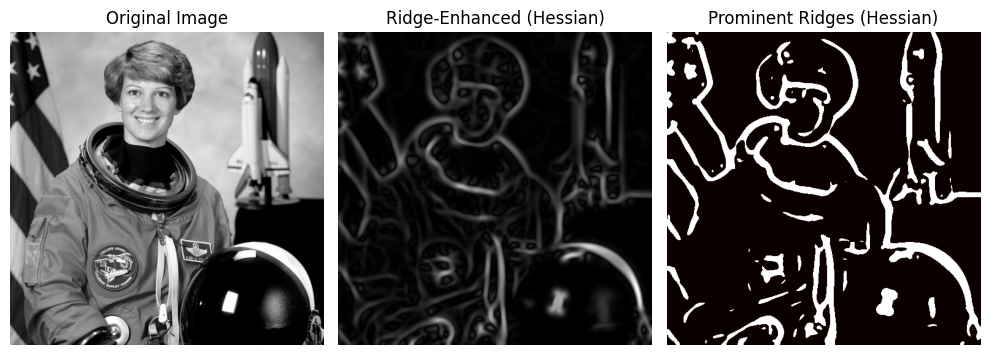

In [233]:
# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(im, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(ridges, cmap='gray')
axes[1].set_title("Ridge-Enhanced (Hessian)")
axes[1].axis("off")

axes[2].imshow(prominent_ridges, cmap='hot')
axes[2].set_title("Prominent Ridges (Hessian)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [234]:
boundary_pts = mask
x, y = mask[:,1], mask[:,0]

In [235]:
def snake_energy(flattened_pts, edge_dist, alpha, beta):

    pts = np.reshape(flattened_pts, (int(len(flattened_pts)/2), 2))
    
    # external energy (favors low values of distance image)
    dist_vals = ndimage.interpolation.map_coordinates(edge_dist, [pts[:,0], pts[:,1]], order=1)
    edge_energy = np.sum(dist_vals)
    external_energy = edge_energy

    # spacing energy (favors equi-distant points)
    prev_pts = np.roll(pts, 1, axis=0)
    next_pts = np.roll(pts, -1, axis=0)

    displacements = pts - prev_pts
    point_distances = np.sqrt(displacements[:,0]**2 + displacements[:,1]**2)
    mean_dist = np.mean(point_distances)
    spacing_energy = np.sum((point_distances - mean_dist)**2) # might change something here

    # curvature energy (favors smooth curves)
    curvature_1d = prev_pts - 2*pts + next_pts
    curvature = (curvature_1d[:,0]**2 + curvature_1d[:,1]**2)
    curvature_energy = np.sum(curvature)
    
    return external_energy + alpha*spacing_energy + beta*curvature_energy


In [236]:
from functools import partial
from scipy import optimize, ndimage
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
def fit_snake(pts, edge_dist, alpha=0.5, beta=0.25, nits=100,):

    # optimize
    cost_function = partial(snake_energy, alpha=alpha, beta=beta, edge_dist=edge_dist)
    options = {'disp':False}
    options['maxiter'] = nits  # FIXME: check convergence
    method = 'BFGS'  # 'BFGS', 'CG', or 'Powell'. 'Nelder-Mead' has very slow convergence
    res = optimize.minimize(cost_function, pts.ravel(), method=method, options=options)
    optimal_pts = np.reshape(res.x, (int(len(res.x)/2), 2))

    return optimal_pts

/var/folders/br/rzkf1nz907qd3q234g81vfm00000gn/T/ipykernel_34155/4156150124.py:6: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  dist_vals = ndimage.interpolation.map_coordinates(edge_dist, [pts[:,0], pts[:,1]], order=1)


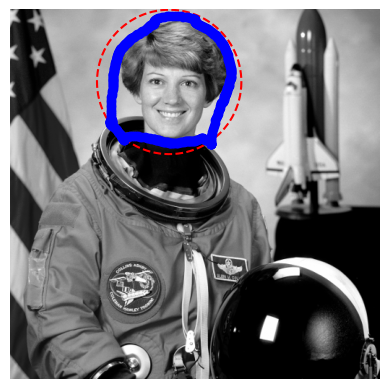

In [238]:
# show an animation of the fitting procedure
fig = plt.figure()
plt.imshow(im, cmap='gray')
plt.plot(boundary_pts[:,1],boundary_pts[:,0], 'r--')

plt.axis('off')

snake_pts = fit_snake(boundary_pts, edge_dist, nits=60, alpha=0.5, beta=10)
plt.imshow(im, cmap='gray')
plt.plot(snake_pts[:,1], snake_pts[:,0], 'bo')
plt.ioff()
plt.pause(0.01)
plt.show()
    